In [8]:
import torch
from Annealing_Flow_Langevin import *

In [ ]:
config = Namespace(hid_dims = "32-32", Xdim_flow = 2)

In [99]:
x_coords = np.linspace(-10, 10, 20)
y_coords = np.linspace(-10, 10, 20)
xs = torch.tensor([[x, y] for y in y_coords for x in x_coords]).to(torch.float32).to(device)
all_xs = [xs]
for i in range(1, 16):
    filepath = f"samplers_trained_Langevin/d=2_truncated_c=3/block{i}.pth"
    checkpt = torch.load(filepath, map_location=torch.device('cpu'), weights_only=False)
    model = default_CNF_structure(config)
    model.load_state_dict(checkpt['model'])
    ls_args_CNF = checkpt['ls_args_CNF']
    xs, _ = FlowNet_forward(xs.to(device), model, ls_args_CNF, i)
    all_xs.append(xs)

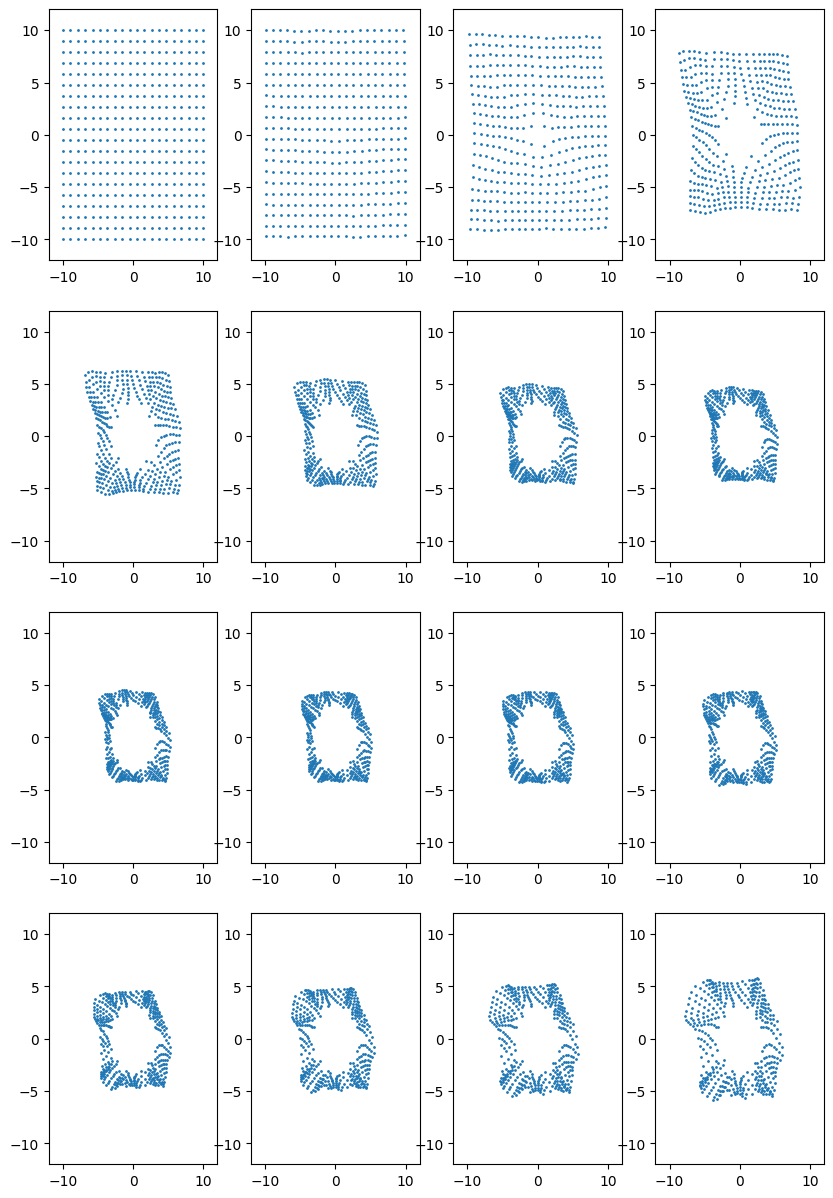

In [101]:
nrow = 4
ncol = 4
fig, axs = plt.subplots(nrow,ncol, figsize=(10,15))
for idx, xs in enumerate(all_xs):
    row = idx // ncol
    col = idx % ncol
    ax = axs[row, col]
    ax.scatter(xs[:, 0].detach().numpy(), xs[:, 1].detach().numpy(), s=1)
    ax.set_xlim(-12, 12)
    ax.set_ylim(-12, 12)

In [102]:
config = Namespace(hid_dims = "32-32", Xdim_flow = 2)

In [103]:
x_coords = np.linspace(-10, 10, 20)
y_coords = np.linspace(-10, 10, 20)
xs = torch.tensor([[x, y] for y in y_coords for x in x_coords]).to(torch.float32).to(device)
all_xs = [xs]
for i in range(1, 16):
    filepath = f"samplers_trained_Langevin/d=2_GMM_sphere_c=8/block{i}.pth"
    checkpt = torch.load(filepath, map_location=torch.device('cpu'), weights_only=False)
    model = default_CNF_structure(config)
    model.load_state_dict(checkpt['model'])
    ls_args_CNF = checkpt['ls_args_CNF']
    xs, _ = FlowNet_forward(xs.to(device), model, ls_args_CNF, i)
    all_xs.append(xs)

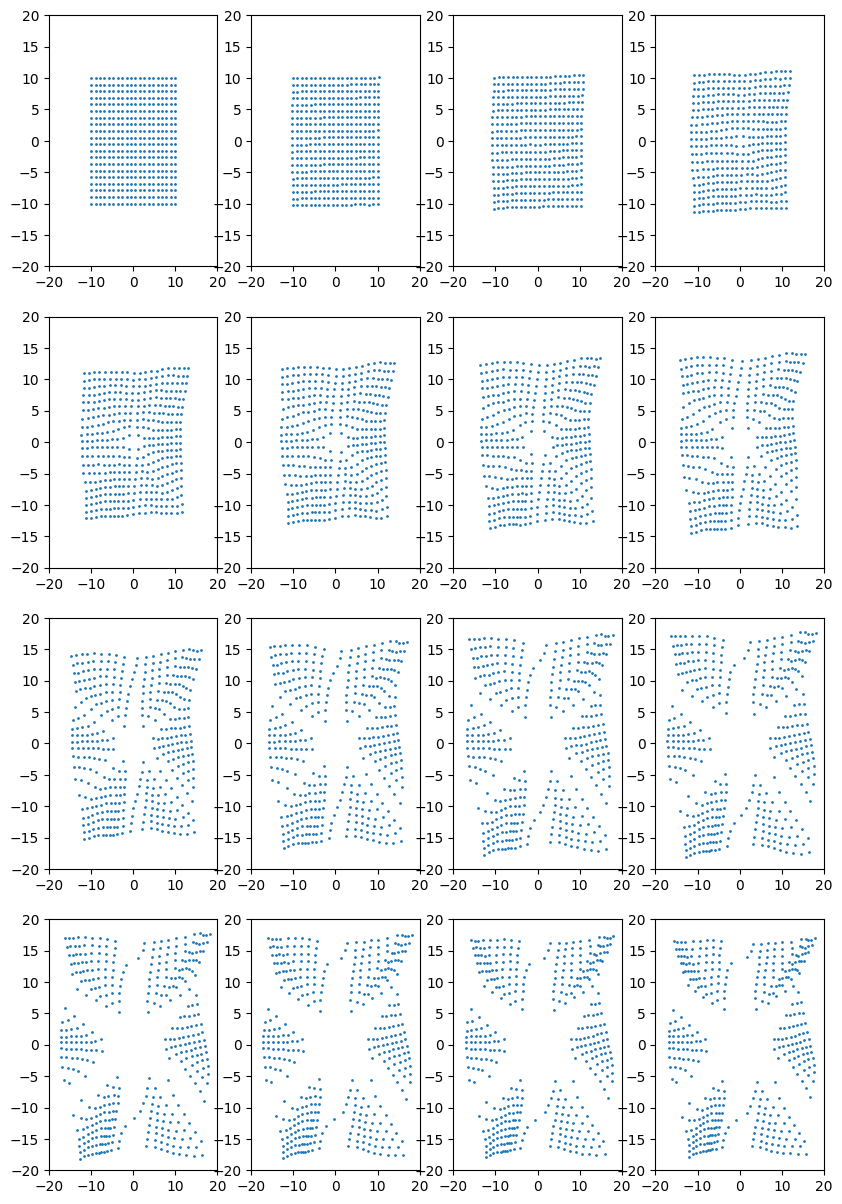

In [104]:
nrow = 4
ncol = 4
fig, axs = plt.subplots(nrow,ncol, figsize=(10,15))
for idx, xs in enumerate(all_xs):
    row = idx // ncol
    col = idx % ncol
    ax = axs[row, col]
    ax.scatter(xs[:, 0].detach().numpy(), xs[:, 1].detach().numpy(), s=1)
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)